# Flood Extent Extraction
This notebook is an end-to-end pipeline for extracting flood extent maps from aerial images. It takes tiled jp2 images as input and returns a single shapefile as output representing the extent of a flood. This particular approach uses trained GMM and XGB models. In performing semantic segmentation, both models return an array of probabilities that a given pixel belongs to a particular label. For the GMM model there are 13 labels with no semantic meaning, but reliably group flood pixels into array indices [1,3,4,5]. The XGB model returns an array of length 5 corresponding to the labels the CSU student team manually labelled [flood, flood + cloud, trees, buildings, land].

All configurable settings are contained within the Notebook Settings cell. The configurable settings are:

 - Image Directory Settings
     - `dataset - String`: s3 bucket containing dataset
     - `image_list_directory` - String: directory containing jp2 images downloaded from s3
 - Output Settings
      - `output_directory` - String: directory for output shapefile objects
 - Log Settings
      - `log_file_prefix` - String: prefix of log files
      - `log_storage_directory` - String: directory for log files 
 - Model Settings
      - `xgb_model_path` - String: directory path of xgb model
      - `gmm_model_path` - String: directory path of gmm model
 - Image & Shapefile Settings
      - `min_contour_size` - Float: the minimum area of a polygon that will be included in the final output, polygons that do not meet this threshold value will be considered false positives (e.g. ponds)
      - `width` - Float: the width to resize input images to before passing the image to the SageMaker Endpoint for flood area prediction

The workflow of this notebook is as follows...
>1. `Setup`
>>This step downloads machine learning and osgr packages necessary for using the XGBClassifier and generating shapefiles from the binary output
>2. `Download Lower Clarence Dataset`
>>The jp2 tiles are downloaded from their s3 bucket
>3. `Image Preprocessing`
>> Before the jp2 images can be passed to the sklearn XGBClassifier, the VGG convolutional network with 'ImageNet' weights is used to extract features, the resulting array is then flattened which is then passed to the XGBClassifier
>4. `XGB Predictions`
>> The XGBClassifier returns probabilities of each pixel belonging to one of the five labels from the semantic segmentation training job, the probabilities at indices 0 and 1 are extracted and combined into a binary image, combined probabilties greater than 0.15 are assumed to be true positives
>5. `GMM Predictions`
>> The GMM performs the same step as above except the probabilities from indices 1, 3, 4, 5 are extracted and combined, again probabilities greater than 0.15 are assumed to be true positives
>6. `Combine XGB and GMM Output`
>> Each of the 6 extracted probabilites from the XGB and GMM models are averaged, resulting values greater than 0.15 produce a binary image of the predicted flood extent
>7. `Combine Binary Images and Extract Contours`
>> The binary images of the flood areas are combined into one large binary image which is then used for extracting contours and generating a large single shapefile.
>8. `Generate Shapefiles`
>> Contours are extracted from the hyrbid binary images and shapefiles are generated for use in GIS software

## `1. Setup`

In [1]:
#conda commands for environment setup
%conda install -c conda-forge gdal fiona rasterio

#pip commands in case conda cant get the required packages
!pip install 'opencv-python>=4.5.3.56' # required as older versions fail opening some jp2 images

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.10.3

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs:
    - fiona
    - gdal
    - rasterio


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    affine-2.3.0               |             py_0          16 KB  conda-forge
    astroid-2.5                |   py36h5fab9bb_1         297 KB  conda-forge
    flask-cors-3.0.8           |             py_0          14 KB  conda-forge
    fsspec-0.8.7               |     pyhd8ed1ab_0          72 KB  conda-forge
    gdal-3.2.1   

In [2]:
!pip install tensorflow
!pip install keras
!pip install xgboost
!pip install lightgbm

     |████████████████████████████████| 458.3 MB 25 kB/s /s eta 0:00:01
     |████████████████████████████████| 3.9 MB 92.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 100.5 MB/s eta 0:00:01
     |████████████████████████████████| 462 kB 133.1 MB/s eta 0:00:01
     |████████████████████████████████| 5.8 MB 70.6 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 8.3 MB/s s eta 0:00:01
     |████████████████████████████████| 42 kB 2.9 MB/s s eta 0:00:01
     |████████████████████████████████| 131 kB 145.1 MB/s eta 0:00:01
     |████████████████████████████████| 4.9 MB 68.3 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 14.0 MB/s  eta 0:00:01
     |████████████████████████████████| 154 kB 142.1 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 96.1 MB/s eta 0:00:01
     |████████████████████████████████| 155 kB 131.4 MB/s eta 0:00:01
     |████████████████████████████████| 146 kB 132.8 MB/s eta 0:00:01
  Created wheel for clang

In [4]:
%%time

import os
import sys
import logging
import datetime
import boto3
import re
import copy
import shutil
import time
from time import gmtime, strftime
import sagemaker
from sagemaker import get_execution_role

import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from skimage.transform import rescale

from osgeo import gdal
from osgeo import osr
import fiona
import rasterio
from rasterio.io import MemoryFile
import rasterio.merge

from keras.models import Model
from keras.applications.vgg16 import VGG16

import tensorflow as tf
import keras
import lightgbm as lgb

from IPython.display import clear_output

role = get_execution_role()
region = boto3.Session().region_name
sess = sagemaker.Session()

region = boto3.Session().region_name
smclient = boto3.Session().client('sagemaker')

print(region)
print(smclient)

ap-southeast-2
CPU times: user 148 ms, sys: 27.4 ms, total: 176 ms
Wall time: 227 ms


## `Notebook Settings`

In [5]:
import os
# URL of S3 bucket containing JP2 images
dataset = "s3://ss-csu-dataset/tiles/LowerClarence/"
with open("dataset.txt", "w") as f:
    f.write("%s" %dataset)
# image directory to store dataset JP2 images
image_list_directory = "../../Images/"
os.makedirs(image_list_directory, exist_ok=True)
# output directory of shapefiles generated from inference images
output_directory = "../../Out"
os.makedirs(output_directory, exist_ok=True)
# log file constants
log_file_prefix = "NOTEBOOK_LOG"
log_storage_directory = "../../Logs"
os.makedirs(log_storage_directory, exist_ok=True)
# gmm and xgb model paths
xgb_model_path = "../../Models/model_XGB_softprob_v04.sav"
gmm_model_path = "../../Models/gmm_1_3_4_5_v2_master_image_nrg_0.1.gmm"
# ensure flood areas > 100 pixels
min_contour_size = 100
# image resize constant
width = 1000
raster_shp_output_prefix = "demo"

In [6]:
cell_error = False

if not 'logger_initiated' in globals():
    logger = logging.getLogger(log_file_prefix) 
    # use different log level for file and console
    timestamp = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')
    formatter = logging.Formatter('[%(asctime)s] %(name)s %(levelname)s - %(message)s')
    
    # file settings
    filename = os.path.join(log_storage_directory, f"{log_file_prefix}_{timestamp}.log") 
    try:
        file_handler = logging.FileHandler(filename=filename)
        file_handler.setLevel(logging.DEBUG)
        file_handler.setFormatter(formatter)
        # stream stdout settings
        stream_handler = logging.StreamHandler(sys.stdout)
        stream_handler.setLevel(logging.INFO)
        stream_handler.setFormatter(formatter)
        # handlers have to be at a root level since they are the final output
        logger.addHandler(stream_handler)
        logger.addHandler(file_handler)
        
        # log global debug to a separate file, log file will include debug logs from import modules
        global_filename = os.path.join(log_storage_directory, f"{log_file_prefix}_EXTRA_{timestamp}.log") 
        file_handler = logging.FileHandler(filename=global_filename)
        file_handler.setLevel(logging.DEBUG)
        file_handler.setFormatter(formatter)
        logging.basicConfig(
        level=logging.DEBUG,
        handlers=[
            file_handler
        ])
        logger.info(f"Finished configuring logging. Log file: {filename}, Global log file: {global_filename}")
        logger_initiated = True
    except Exception as e:
        cell_error = True
        logger.error(f"Unable to configure logging: {e}.")
else:
    logger.warning(f"Logger is already configured. Log file: {filename}, Global log file: {global_filename}")
    
if cell_error:
    raise SystemExit("Execution stopped...")

[2021-10-17 02:09:48,361] NOTEBOOK_LOG INFO - Finished configuring logging. Log file: ../../Logs/NOTEBOOK_LOG_20211017_02-09-48.log, Global log file: ../../Logs/NOTEBOOK_LOG_EXTRA_20211017_02-09-48.log


In [7]:
# log settings to file
logger.debug(f"Notebook settings:\n"
            f"\t\t\t\t\t\t dataset {dataset}\n"
            f"\t\t\t\t\t\t xgb_model {xgb_model_path}\n"
            f"\t\t\t\t\t\t gmm_model {gmm_model_path}\n"
            f"\t\t\t\t\t\t image_width {width}\n"
            f"\t\t\t\t\t\t minimum_contour_size {min_contour_size}\n"
            f"\t\t\t\t\t\t output_directory {output_directory}\n"
            f"\t\t\t\t\t\t log_file_prefix {log_file_prefix}\n"
            f"\t\t\t\t\t\t log_storage_directory {log_storage_directory}")

In [8]:
# utility methods

def vgg_model():
    """Load VGG16 model without training layers. Return top 3 convolutional layers for feature extraction.
    """
    #Load VGG16 model wothout classifier/fully connected layers
    #Load imagenet weights that we are going to use as feature generators
    VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(1000,1000,3))
    #Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
    for layer in VGG_model.layers:
        layer.trainable = False
    VGG_model.summary()  #Trainable parameters will be 0
    return Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)


def make_square(img):
    """Takes a non-square image and adds 'negative space' to the image so height == width
    
    Parameters:
    img - an image of type np.array
    """
    #Getting the bigger side of the image
    #s = max(img.shape[0:2])
    s = 10000
    #new image shape
    try:
        #multi channel images
        np_shape = (s,s,img.shape[2])
    except:
        #single channel image (grey scale)
        np_shape = (s,s)
    #Creating a dark square with NUMPY
    f = np.zeros(np_shape,np.uint8)
    #Position imagein top left to maintain geodetic accuracy
    ax,ay = (0,0)
    #Pasting the 'image' in a centering position
    f[ay:img.shape[0]+ay,ax:ax+img.shape[1]] = img
    return f


def remove_noise(comp_img, neg_img):
    """Removes false positives from binary image.
    
    Parameters:
    comp_img: binary image of flood including false positive area
    neg_img: binary image highlighting only the false positive area
    """
    for i in range(comp_img.shape[0]):
        for j in range(comp_img.shape[1]):
            if comp_img[i][j] == True:
                if neg_img[i][j] == True:
                    comp_img[i][j] = False
    return comp_img

## `2. Download Lower Clarence Dataset`

In [6]:
!aws s3 cp $(cat dataset.txt) ../../Images/ --recursive --exclude "*" --include "*.jp2"

download: s3://ss-csu-dataset/tiles/LowerClarence/Lower_Clarence_Flood_2021_03_16cm_NRG_1.jp2 to ../../Images/lower_clarence/Lower_Clarence_Flood_2021_03_16cm_NRG_1.jp2
download: s3://ss-csu-dataset/tiles/LowerClarence/Lower_Clarence_Flood_2021_03_16cm_NRG_103.jp2 to ../../Images/lower_clarence/Lower_Clarence_Flood_2021_03_16cm_NRG_103.jp2
download: s3://ss-csu-dataset/tiles/LowerClarence/Lower_Clarence_Flood_2021_03_16cm_NRG_102.jp2 to ../../Images/lower_clarence/Lower_Clarence_Flood_2021_03_16cm_NRG_102.jp2
download: s3://ss-csu-dataset/tiles/LowerClarence/Lower_Clarence_Flood_2021_03_16cm_NRG_10.jp2 to ../../Images/lower_clarence/Lower_Clarence_Flood_2021_03_16cm_NRG_10.jp2
download: s3://ss-csu-dataset/tiles/LowerClarence/Lower_Clarence_Flood_2021_03_16cm_NRG_101.jp2 to ../../Images/lower_clarence/Lower_Clarence_Flood_2021_03_16cm_NRG_101.jp2
download: s3://ss-csu-dataset/tiles/LowerClarence/Lower_Clarence_Flood_2021_03_16cm_NRG_100.jp2 to ../../Images/lower_clarence/Lower_Clarence

## `3. Image Preprocessing`

In [9]:
%%time
cell_error = False
try:
    
    xgb_img_list = []
    gmm_img_list = []
    img_path = "../../Images/"
    counter = 1
    for file in os.listdir(img_path):
        print(f"opening {file} {counter}/{len(os.listdir(img_path))}")
        img = cv2.imread(os.path.join(img_path, file))
        #img = make_square(img) # not needed for lower clarence dataset
        scale = width/img.shape[0]
        print(f"image width: {img.shape[0]}\nrescale width: {width}\nscale: {scale}\nimage shape: {img.shape}")
        gmm_img = rescale(img.copy(), scale, anti_aliasing=False, multichannel=True)
        gmm_img_list.append(gmm_img)
        aspect = img.shape[1]/img.shape[0]
        xgb_img = cv2.resize(img, (width,int(width/aspect)), interpolation=cv2.INTER_NEAREST)
        xgb_img = cv2.cvtColor(xgb_img, cv2.COLOR_RGB2BGR)
        xgb_img_list.append(xgb_img)
        print(f"resize image shape: {xgb_img.shape}")

        counter += 1
        clear_output(wait=True)

    xgb_img_list = np.array(xgb_img_list)
    gmm_img_list = np.array(gmm_img_list)
except Exception as e:
    logger.error(f"Unable to open images: {e}")
    cell_error = True
    
if cell_error:
    raise SystemExit("Execution Stopped")

CPU times: user 17min 17s, sys: 2min 13s, total: 19min 31s
Wall time: 18min 45s


In [10]:
cell_error = False

try:
    new_model = vgg_model()
    new_model.summary()
except Exception as e:
    logger.error(f"Unable to download VGG model: {e}")
    cell_error = True
    
if cell_error:
    raise SystemExit("Execution Stopped")

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 1000, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 1000, 1000, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 1000, 1000, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 500, 500, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 500, 500, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 500, 500, 128)     147584    
______________________________________________________________

In [11]:
%%time
cell_error = False

try:    
    feature_vector = new_model.predict(xgb_img_list)
    print(f"feature vector: {feature_vector.shape}")
    feature_vector = feature_vector.reshape(-1, feature_vector.shape[3])
    print(f"input shape: {feature_vector.shape}")
except Exception as e:
    logger.error(f"Unable to extract feature vector: {e}")
    cell_error = True

if cell_error:
    raise SystemExit("Execution Stopped")

feature vector: (176, 1000, 1000, 64)
input shape: (176000000, 64)
CPU times: user 7min 7s, sys: 2min 18s, total: 9min 25s
Wall time: 32.3 s


In [12]:
cell_error = False

try: 
    gmm_model = pickle.load(open(gmm_model_path, 'rb'))
    xgb_model = pickle.load(open(xgb_model_path, 'rb'))
except Exception as e:
    logger.error(f"Unable to load models: {e}")
    cell_error = True
    
if cell_error:
    raise SystemExit("Execution Stopped")

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## `4. XGB Predictions`

output shape: (176, 1000, 1000, 5)
CPU times: user 18min 11s, sys: 2.61 s, total: 18min 14s
Wall time: 28.5 s


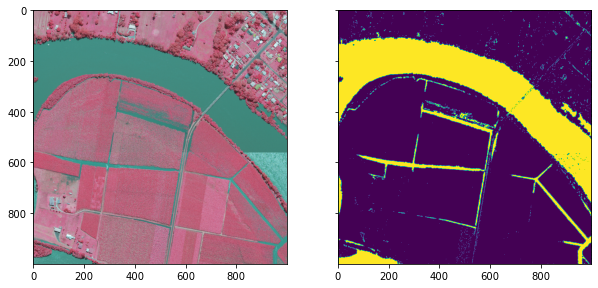

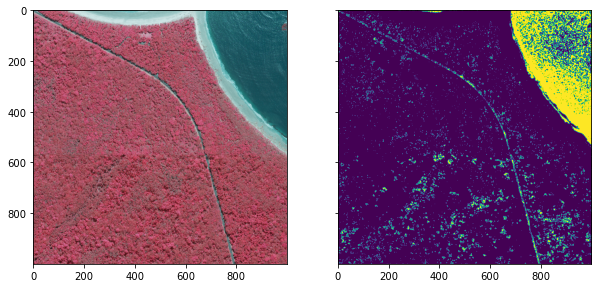

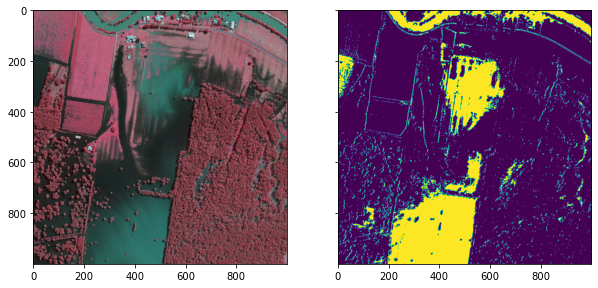

In [13]:
%%time
cell_error = False

xgb_flood = []
xgb_flood_clusters = (0,1)

try:
    num_classes = 5
    xgb_proba = xgb_model.predict_proba(feature_vector)
    xgb_proba = xgb_proba.reshape((xgb_img_list.shape[0], xgb_img_list.shape[1], xgb_img_list.shape[2], num_classes))
    print(f"output shape: {xgb_proba.shape}")

    for output in xgb_proba:
        hp_joined_img = np.greater(output[:,:,xgb_flood_clusters[0]],0.15)
        hp_joined_img = np.logical_or(hp_joined_img, np.greater(output[:,:,xgb_flood_clusters[1]],0.15))
        xgb_flood.append(hp_joined_img)
        
except Exception as e:
    logger.error(f"Unable to complete xgb predictions: {e}")
    cell_error = True
    
if cell_error:
    raise SystemExit("Execution Stopped")
    
for i in range(3):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10,20))
    ax[0].imshow(xgb_img_list[i])
    ax[1].imshow(xgb_flood[i])

## `5. GMM Predictions`

CPU times: user 1h 7min 56s, sys: 1h 12min 41s, total: 2h 20min 37s
Wall time: 4min 2s


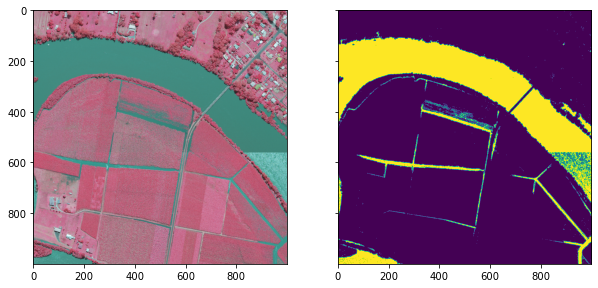

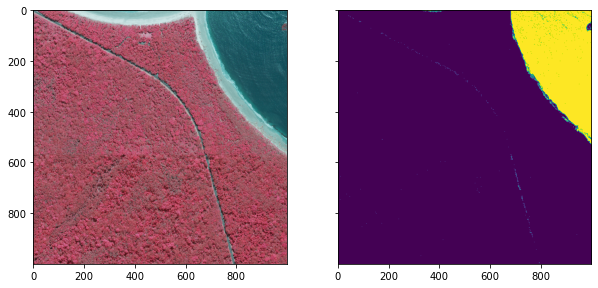

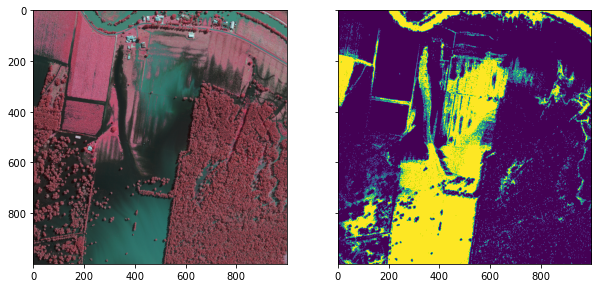

In [14]:
%%time
cell_error = False

    
gmm_flood = []
gmm_proba_list = []
gmm_flood_clusters = (1,3,4,5)

try:
    counter = 1
    for img in gmm_img_list:
        print(f"predicting image {counter}/{len(gmm_img_list)}")
        #print(img.shape[:2])
        channels = img.shape[-1]
        vectorized_img = img.reshape((-1, channels))
        gmm_proba = gmm_model.predict_proba(vectorized_img)
        #print(f"raw output shape: {gmm_proba.shape}")
        gmm_proba = gmm_proba.reshape(img.shape[:2] + (gmm_proba.shape[-1],))
        gmm_proba_list.append(gmm_proba)
        #print(f"adjusted output shape: {gmm_proba.shape}")
        hp_joined_img = np.greater(gmm_proba[:,:,gmm_flood_clusters[0]],0.15)
        for c in range(1, len(gmm_flood_clusters)):
                hp_joined_img = np.logical_or(hp_joined_img, np.greater(gmm_proba[:,:,gmm_flood_clusters[c]],0.15)) 
        gmm_flood.append(hp_joined_img)
        counter += 1
        clear_output(wait=True)

except Exception as e:
    logger.error(f"Unable to perfrom GMM predictions: {e}")
    cell_error = True
    
if cell_error:
    raise SystemExit("Execution Stopped")
    
for i in range(3):
    fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10,20))
    ax[0].imshow(xgb_img_list[i])
    ax[1].imshow(gmm_flood[i])

## `6. Combine XGB and GMM Output`

In [15]:
%%time
cell_error = False

hybrid_img_list = []

try:

    for i in range(len(xgb_proba)):
        xgb_proba_01 = xgb_proba[i][:,:,xgb_flood_clusters[0]]
        xgb_proba_02 = xgb_proba[i][:,:,xgb_flood_clusters[1]]
        gmm_proba_01 = gmm_proba_list[i][:,:,gmm_flood_clusters[0]]
        gmm_proba_02 = gmm_proba_list[i][:,:,gmm_flood_clusters[1]]
        gmm_proba_03 = gmm_proba_list[i][:,:,gmm_flood_clusters[2]]
        gmm_proba_04 = gmm_proba_list[i][:,:,gmm_flood_clusters[3]]
        avg_img = (xgb_proba_01 + xgb_proba_02 + gmm_proba_01 + gmm_proba_02 + gmm_proba_03 + gmm_proba_04) / 6
        flood_img = np.greater(avg_img, 0.15)
        hybrid_img_list.append(flood_img)

    hybrid_img_list = np.array(hybrid_img_list)
    print(f"output shape: {hybrid_img_list.shape}")

except Exception as e:
    logger.error(f"Unable to combine XGB and GMM output: {e}")
    cell_error = True
    
if cell_error:
    raise SystemExit("Execution Stopped")

output shape: (176, 1000, 1000)
CPU times: user 6 s, sys: 143 ms, total: 6.15 s
Wall time: 6.15 s


## `6.1 Remove False Positives`

In [ ]:
"""
cell_error = False

### NOT NEEDED FOR LOWER CLARENCE DATASET ###

try:
    neg_mask_list = []
    for i in range(len(xgb_img_list)):
        temp_img = cv2.cvtColor(xgb_img_list[i], cv2.COLOR_BGR2GRAY)
        temp_mask = np.zeros(temp_img.shape)
        temp_mask = temp_img == 0
        neg_mask_list.append(temp_mask)

    final_mask_list = []

    for i in range(len(hybrid_img_list)):
        comp_img = hybrid_img_list[i].copy()
        neg_img = neg_mask_list[i]
        temp_img = remove_noise(comp_img, neg_img)
        final_mask_list.append(temp_img)
except Exception as e:
    logger.error(f"Unable to remove false positives: {e}")
    cell_error = True
    
hyrbid_img_list = final_mask_list
hybrid_img_list = np.array(hybrid_img_list)
    
if cell_error:
    raise SystemExit("Execution Stopped")
"""

## `7. Combine Binary Images & Extract Contours`

In [16]:
%%time
cell_error = False
# open images as geo data sets
logger.info(f"Combining images")
datasets = []
try:
    for i, file in enumerate(os.listdir(img_path)):
        logger.debug(f"Opening {file}")
        ds = rasterio.open(f"../../Images/lower_clarence/{file}")
        # get dataset profile
        profile = ds.profile
        profile.update(
            dtype=rasterio.uint8,
            count=2)
        ds.close()
        # append data set to array
        logger.debug(f"Opening temporary memory file for binary image")
        memfile = MemoryFile()
        mem_ds = memfile.open(**profile)
        mem_ds.write(hybrid_img_list[i], 1)
        datasets.append(mem_ds)
    #combine datasets and save to disk
    timestamp = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')
    raster_file = os.path.join(output_directory, f"{raster_shp_output_prefix}_{timestamp}.jp2")
    logger.debug(f"Merging {len(datasets)} binary images and writing to {raster_file}")
    rasterio.merge.merge(datasets, dst_path=raster_file, dst_kwds=profile)
    # open dataset and read flood layer
    logger.debug(f"Opening binary raster image as raster dataset")
    merged_dataset = rasterio.open(raster_file)
    logger.debug(f"Reading flood extent raster")
    flood_layer = merged_dataset.read(1)
    
except Exception as e:
    logger.error(f"Error combining images: {e}", exc_info=True)
    cell_error = True
    
if cell_error:
    raise SystemExit("Execution Stopped") 
else:  
    logger.info(f"Finished combining images")

[2021-10-17 02:46:23,596] NOTEBOOK_LOG INFO - Combining images
[2021-10-17 02:52:18,529] NOTEBOOK_LOG INFO - Finished combining images
CPU times: user 16min 4s, sys: 13min 9s, total: 29min 13s
Wall time: 5min 54s


In [18]:
cell_error = False
try:
    contour_results = []
    i = 0
    logger.info(f"Started contouring binary image")
    contours, hierachy = cv2.findContours(np.uint8(flood_layer), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # eliminate contours less than minimum area
    for c in range(len(contours)):
        if cv2.contourArea(contours[c]) > min_contour_size:
            contour_results.append(contours[c])
            # reverse orientation to create holes in shape 
            if hierachy[0][c][3] != -1:
                contour_results[-1] = np.flipud(contour_results[-1])

    logger.info(f"Found {len(contour_results)} contours, {len(contours) - len(contour_results)} eliminated")
except Exception as e:
    logger.error(f"Error contouring images: {e}", exc_info=True)
    cell_error = True

if cell_error:
    raise SystemExit("Execution Stopped") 
else:  
    logger.info(f"Finished contouring / creating polygons")

[2021-10-17 03:07:54,564] NOTEBOOK_LOG INFO - Started contouring binary image
[2021-10-17 03:09:05,938] NOTEBOOK_LOG INFO - Found 136446 contours, 514644 eliminated
[2021-10-17 03:09:05,938] NOTEBOOK_LOG INFO - Finished contouring / creating polygons


## `8. Generate Shapefiles`

In [19]:
def pixel2location(dx,dy):
    '''Convert pixel coordinates to spatial coordinates
    dx: x axis pixel
    dy: y axis pixel
    '''
    x = dx * pixel_x_size + pixel_x_offset
    y = dy * pixel_y_size + pixel_y_offset
    return x,y

# define shp schema
schema = {
    'geometry':'MultiPolygon',
    'properties':[('tag','str')]
}

cell_error = False
logger.info("Started converting contours / polygons to shape file")

# get the transform data
transform = merged_dataset.transform
pixel_x_offset = transform[2]
pixel_x_size = transform[0]
pixel_y_offset = transform[5]
pixel_y_size = transform[4]
logger.debug(f"Spatial data: X pixel width = {pixel_x_size}m, Y pixel height = {pixel_y_size}m, pixel (0, 0) location = {pixel_x_offset}, {pixel_y_offset}")

# loop through each contour
if len(contour_results) > 0:
    logger.debug(f"{len(contour_results)} polygons will be created")
# Convert pixel data points to spatial
multi_polygon = []
for contour in range(len(contour_results)):
    polygon = []
    multi_polygon.append(polygon)
    # convert polygon pixel points to spatial points and store  
    for pixel in contour_results[contour]:
        #convert
        x, y = pixel2location(pixel[0][0], pixel[0][1])
        #store
        polygon.append([x, y])

# write to shape file
shp_file_output = os.path.join(output_directory, f"{raster_shp_output_prefix}_{timestamp}.shp")
logger.debug(f"Writing {shp_file_output}")
try:
    with fiona.open(shp_file_output, 'w', 'ESRI Shapefile', schema=schema, crs=merged_dataset.crs) as shp_file:
        logger.debug(f"Shape file espg: {shp_file.crs}")
        shp_file.write({
            'geometry' : {'type':'MultiPolygon',
            'coordinates': [multi_polygon]}, # Here the xyList is in brackets
            'properties': {
                'tag': ' flood extent'
            }
        })

except Exception as e:
    logger.error(f"Unable to write shape file {shp_file_output}: {e}", exc_info=True)
    cell_error = True
else:
     logger.debug(f"No polygons. No shape file will be generated")
        
if cell_error:
    logger.warn(f"Finished converting polygons to shape file with errors")
else:
    logger.info(f"Finished converting polygons to shape file")

[2021-10-17 03:28:31,151] NOTEBOOK_LOG INFO - Started converting contours / polygons to shape file
[2021-10-17 04:08:16,828] NOTEBOOK_LOG INFO - Finished converting polygons to shape file


In [21]:
try:
    x = datetime.datetime.now()
    zip_file_name = (f"{x.year}{x.month}{x.day}{x.hour}{x.minute}_Outputs")
    zip_file = os.path.join(f"{output_directory}/../", zip_file_name)
    logger.info(f"Starting compression of {output_directory}, writing to {zip_file}.zip")
    shutil.make_archive(f"{zip_file}", 'zip', output_directory)
    logger.info(f"Success compressing and writing outputs to {zip_file}.zip")
    logger.info(f"Cleaning up")
    logger.info(f"Removing files from images storage {image_list_directory}")
    for file in os.listdir(image_list_directory):
        if file.endswith(".zip") or os.path.isdir(file):
            pass
        else:
            os.remove(os.path.join(image_list_directory, file))
    logger.info(f"Removing files from outputs storage {output_directory}")
    for file in os.listdir(output_directory):
        if file.endswith(".zip") or os.path.isdir(file):
            pass
        else:
            os.remove(os.path.join(output_directory, file))
except Exception as e:
    logger.error(f"Unable to compress and clean up: {e}", exc_info=True)

[2021-10-17 05:24:03,391] NOTEBOOK_LOG INFO - Starting compression of ../../Out, writing to ../../Out/../20211017524_Outputs.zip
[2021-10-17 05:24:15,769] NOTEBOOK_LOG INFO - Success compressing and writing outputs to ../../Out/../20211017524_Outputs.zip
[2021-10-17 05:24:15,770] NOTEBOOK_LOG INFO - Cleaning up
[2021-10-17 05:24:15,770] NOTEBOOK_LOG INFO - Removing files from images storage ../../Images/
[2021-10-17 05:24:15,771] NOTEBOOK_LOG ERROR - Unable to compress and clean up: [Errno 21] Is a directory: '../../Images/lower_clarence'
Traceback (most recent call last):
  File "<ipython-input-21-151365f6d37a>", line 14, in <module>
    os.remove(os.path.join(image_list_directory, file))
IsADirectoryError: [Errno 21] Is a directory: '../../Images/lower_clarence'
